# **Code for data augmentation (Part 1).**

**STEP 1 : Loading the dataset**

Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns


Loading dataset

In [ ]:
df = pd.read_csv("/customer_transactions.csv")
df.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


**Step 2: Data Cleaning & Handling Missing Values**

In [ ]:
# Identify missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


From the above results we obltained,the only column with missing values is customer_rating (10 missing values).To solve this , l will fill in missing values with mean.

Handling The Missing Values

In [ ]:
# Mean imputation for numerical column 'customer_rating'
if df['customer_rating'].isnull().sum() > 0:
    df['customer_rating'] = df['customer_rating'].fillna(df['customer_rating'].mean())
    print("Filled missing customer_rating with mean value.")
print("Missing values after mean imputation:")
print(df.isnull().sum())

Filled missing customer_rating with mean value.
Missing values after mean imputation:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


In [ ]:
# Median imputation for 'purchase_amount'
if df['purchase_amount'].isnull().sum() > 0:
    df['purchase_amount'] = df['purchase_amount'].fillna(df['purchase_amount'].median())
    print("Filled missing purchase_amount with median value.")
print("Missing values after median imputation:")
print(df.isnull().sum())

Missing values after median imputation:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


It seems like we have resolved the missing value issue!

In [ ]:
# Mode imputation for categorical column 'product_category'
if df['product_category'].isnull().sum() > 0:
    df['product_category'] = df['product_category'].fillna(df['product_category'].mode()[0])
    print("Filled missing product_category with mode value.")
print("Missing values after mode imputation:")
print(df.isnull().sum())

Missing values after mode imputation:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


In [ ]:
# Predictive modeling (KNN Imputer) for numerical missing values
knn_imputer = KNNImputer(n_neighbors=5)
df[['customer_rating']] = knn_imputer.fit_transform(df[['customer_rating']])
print("Applied KNN imputation to customer_rating.")
print("Missing values after KNN imputation:")
print(df.isnull().sum())

Applied KNN imputation to customer_rating.
Missing values after KNN imputation:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


As you can see all the other methods we used after already solving the missing values in customer_rating were just repetitive steps, they didn't return anything or make any changes to our data ! We used them for verifying only.

**Step 3: Data Augmentation Strategies**

Synthetic Data Generation Part

In [ ]:
print(df[['purchase_amount']].head())

   purchase_amount
0              408
1              332
2              442
3              256
4               64


Applying random noise to numerical transaction values.

In [ ]:
df['purchase_amount'] = df['purchase_amount'] + np.random.normal(loc=0, scale=5, size=len(df))

print(df[['purchase_amount']].head())

   purchase_amount
0       406.088830
1       332.320135
2       444.207936
3       254.335779
4        62.292957


Checking if dataset is balanced or not

In [ ]:
# Check the distribution of the target variable
print(df['product_category'].value_counts())


product_category
Sports         35
Electronics    34
Clothing       28
Groceries      28
Books          25
Name: count, dtype: int64


Let's visualize this

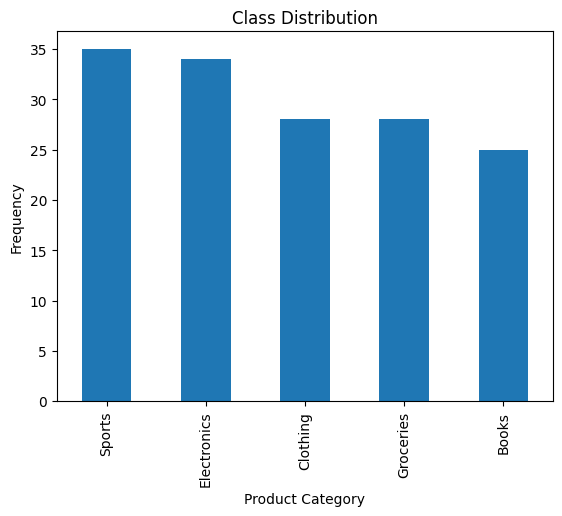

In [ ]:
import matplotlib.pyplot as plt

df['product_category'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Product Category')
plt.ylabel('Frequency')
plt.show()


Balancing the Dataset Using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Defining features (X) and target (y)
X = df[['purchase_amount']]
y = df['product_category']

# Applying SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Creating new balanced DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['purchase_amount'])
df_resampled['product_category'] = y_resampled

# Verifying class distribution
print(df_resampled['product_category'].value_counts())


product_category
Sports         35
Electronics    35
Clothing       35
Groceries      35
Books          35
Name: count, dtype: int64


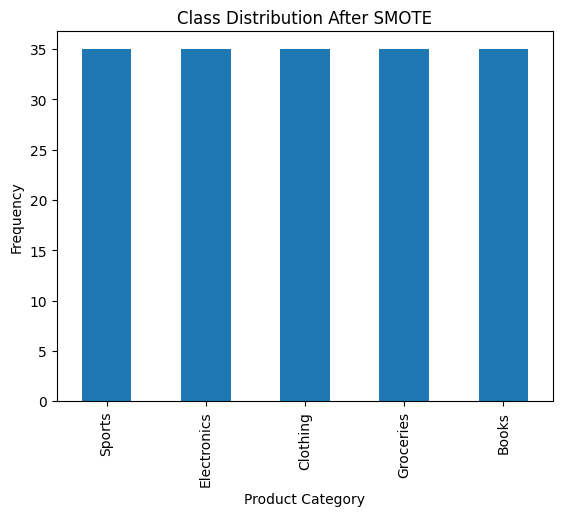

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of the target variable in the resampled dataset
df_resampled['product_category'].value_counts().plot(kind='bar')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Product Category')
plt.ylabel('Frequency')
plt.show()


Applying Log Transformation (Feature Value Transformation)

In [ ]:
# Applying log transformation to 'purchase_amount' to reduce skewness
df['log_purchase_amount'] = np.log1p(df['purchase_amount'])

# Verifying transformation
df[['purchase_amount', 'log_purchase_amount']].head()


,purchase_amount,log_purchase_amount
0,406.088830,6.009031
1,332.320135,5.809103
2,444.207936,6.098541
3,254.335779,5.542579
4,62.292957,4.147774


Generating New Synthetic Transactions to expand our dataset

In [ ]:
# Generating synthetic transactions by duplicating and adding noise
num_synthetic = 500
synthetic_data = df.sample(num_synthetic, replace=True)

# Applying random noise
synthetic_data['purchase_amount'] += np.random.normal(0, 5, size=num_synthetic)

# Appending to original DataFrame
df_augmented = pd.concat([df, synthetic_data], ignore_index=True)

# Verifying new dataset size
print("Original dataset size:", len(df))
print("New dataset size after augmentation:", len(df_augmented))


Original dataset size: 150
New dataset size after augmentation: 650


Now that we have managed to successfully expand our dataset, let's save it!

In [ ]:
# Saving cleaned & augmented dataset
df_augmented.to_csv("customer_transactions_augmented.csv", index=False)
